In [1]:

!unzip data.zip


Archive:  data.zip
replace data/test/kick_00.mp3? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
pip install resampy


In [4]:
import os
print(os.getcwd())

filelist = os.listdir("/content/data")

for filename in filelist:
  print(filename)

/content
test
train


In [5]:
train_data = "/content/data/train"

In [6]:
kick_train = "kick_*.mp3"
snare_train = "snare_*.mp3"

In [7]:
kick_train

'kick_*.mp3'

In [8]:
import librosa
import librosa.display

In [9]:


kick_signals = [
    librosa.load(p)[0] for p in Path(train_data).glob(kick_train)
]

snare_signals = [
    librosa.load(p)[0] for p in Path(train_data).glob(snare_train)
]

In [10]:
len(kick_signals), len(snare_signals)


(62, 32)

In [11]:
len(kick_signals), len(snare_signals)


(62, 32)

In [12]:
kick_signals[0].shape


(24548,)

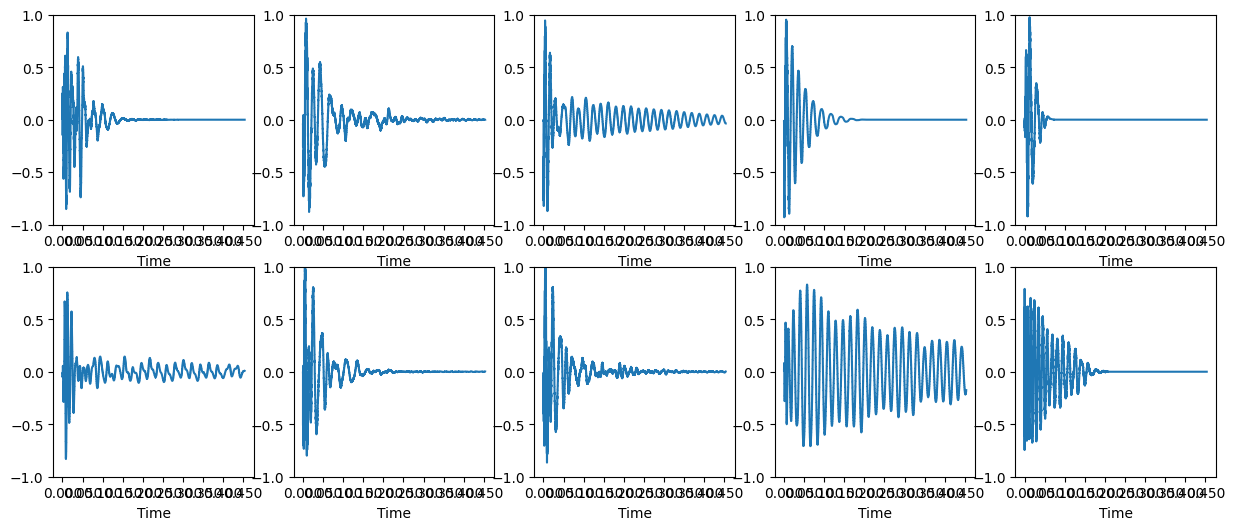

In [13]:
plt.figure(figsize=(15, 6))
for i, x in enumerate(kick_signals[:10]):
    plt.subplot(2, 5, i+1)
    librosa.display.waveshow(x[:10000])
    plt.ylim(-1, 1)

In [14]:
def extract_features(signal):
    return [
        librosa.feature.zero_crossing_rate(signal)[0, 0],
        librosa.feature.spectral_centroid(y=signal)[0, 0],
    ]

In [15]:
kick_features = np.array([extract_features(x) for x in kick_signals])
snare_features = np.array([extract_features(x) for x in snare_signals])

In [16]:
kick_features[1].shape

(2,)

In [17]:
kick_features.shape


(62, 2)

In [18]:
snare_features.shape


(32, 2)

In [19]:
kick_features[0].shape


(2,)

In [20]:
kick_features[0]


array([9.27734375e-03, 1.36612622e+03])

In [21]:
snare_features[0]


array([1.02050781e-01, 2.85601854e+03])

Text(0, 0.5, 'Count')

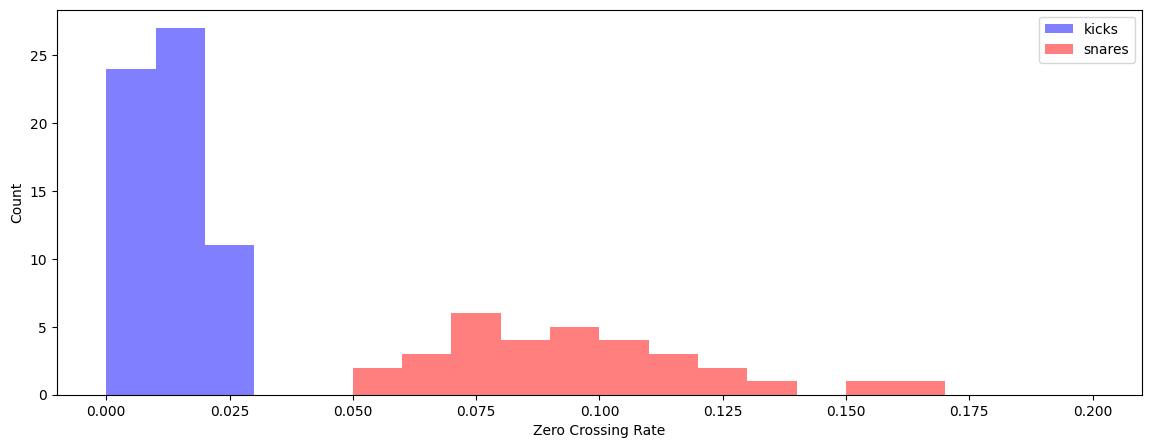

In [22]:
plt.figure(figsize=(14, 5))
plt.hist(kick_features[:,0], color='b', range=(0, 0.2), alpha=0.5, bins=20)
plt.hist(snare_features[:,0], color='r', range=(0, 0.2), alpha=0.5, bins=20)
plt.legend(('kicks', 'snares'))
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

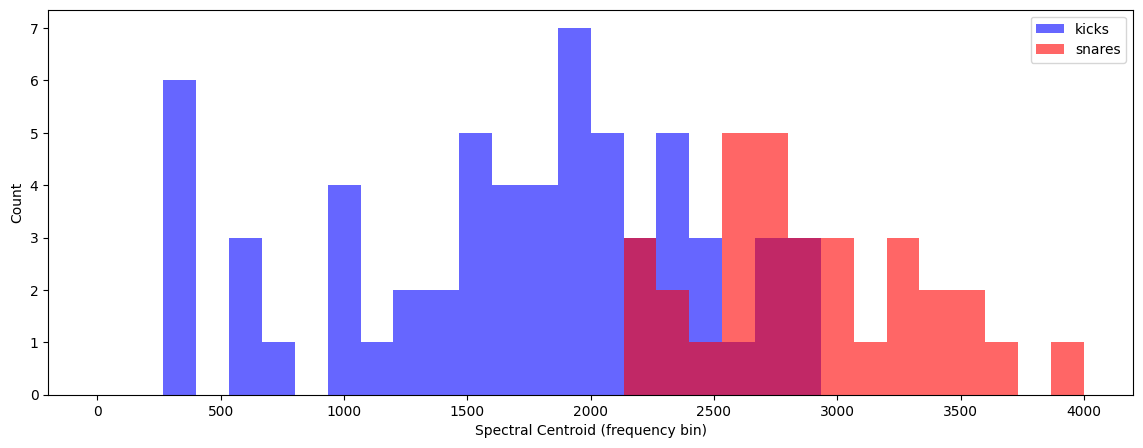

In [23]:
plt.figure(figsize=(14, 5))
plt.hist(kick_features[:,1], color='b', range=(0, 4000), bins=30, alpha=0.6)
plt.hist(snare_features[:,1], color='r', range=(0, 4000), bins=30, alpha=0.6)
plt.legend(('kicks', 'snares'))
plt.xlabel('Spectral Centroid (frequency bin)')
plt.ylabel('Count')

In [24]:
feature_table = np.vstack((kick_features, snare_features))
print(feature_table.shape)


(94, 2)


In [25]:
feature_table = np.vstack((kick_features, snare_features))
print(feature_table.shape)


(94, 2)


In [26]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
training_features = scaler.fit_transform(feature_table)
print(training_features.min(axis=0))
print(training_features.max(axis=0))

[-1. -1.]
[1. 1.]


Text(0, 0.5, 'Spectral Centroid')

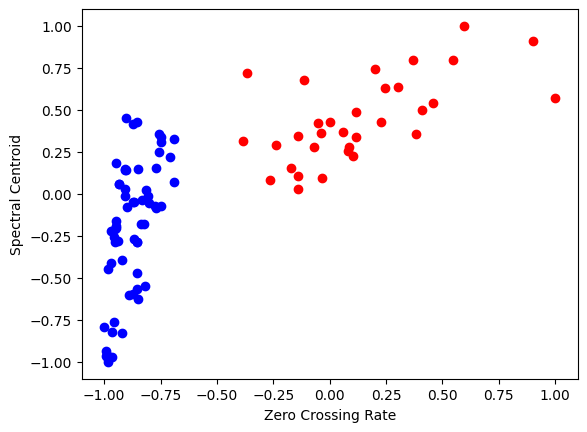

In [27]:
plt.scatter(training_features[:62,0], training_features[:62,1], c='b')
plt.scatter(training_features[62:,0], training_features[62:,1], c='r')
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Spectral Centroid')

In [28]:
y = [0 for i in range(62)] + [1 for i in range(32)]


In [29]:
y[:20]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
y_encoded = to_categorical(y)


In [31]:
y_encoded[:10]


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [32]:
x_train, x_test, y_train, y_test = train_test_split(training_features, y_encoded, test_size=0.2, shuffle=True)


In [33]:
y_train.shape, y_test.shape


((75, 2), (19, 2))

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

In [35]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(2,)))
    model.add(Dense(8))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    return model

In [36]:
model = create_model()
model.summary()
adam_optim = Adam(learning_rate=0.0001)
model.compile(optimizer=adam_optim, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42 (168.00 B)

 Trainable params: 42 (168.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
his1 = model.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=150,
    verbose=1,
    validation_data = (x_test, y_test)
)

Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3553 - loss: 1.0516 - val_accuracy: 0.3158 - val_loss: 1.0164
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2787 - loss: 1.0242 - val_accuracy: 0.3158 - val_loss: 0.9902
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2983 - loss: 1.1144 - val_accuracy: 0.3158 - val_loss: 0.9661
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3226 - loss: 0.9032 - val_accuracy: 0.3158 - val_loss: 0.9415
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3577 - loss: 0.8504 - val_accuracy: 0.3158 - val_loss: 0.9202
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3903 - loss: 0.9269 - val_accuracy: 0.3158 - val_loss: 0.8972
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 0.9262 - val_accuracy: 0.3684 - val_loss: 0.8765
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4371 - loss: 0.9116 - val_accuracy: 0.4737 - 

In [38]:
import plotly
import plotly.graph_objs as go

In [39]:
h1 = go.Scatter(y=his1.history['loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his1.history['val_loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [40]:
h1 = go.Scatter(y=his1.history['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his1.history['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig2 = go.Figure(data = data, layout=layout1)
fig2.show()

In [42]:
# prompt: classification report

from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         6

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

